<a href="https://colab.research.google.com/github/aemiralfath/BPML-Dicoding/blob/master/Daily_Climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=08b77714898ca2377f85730b7c1a72bb720f3cb7bb3e60c3425383ee6e6a15fe
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [3]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 18.2MB/s]


In [4]:
import zipfile

zipref = zipfile.ZipFile('daily-climate-time-series-data.zip', 'r')
zipref.extractall()
zipref.close()

In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display_html

import tensorflow as tf
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler 

In [37]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
data_train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [38]:
data_test = pd.read_csv('DailyDelhiClimateTest.csv')
data_test.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [10]:
data = pd.concat([data_train, data_test])
data.shapecallback = TensorBoard(logdir)

(1576, 5)

In [41]:
data[-116:]

,date,temp,humidity,wind,pressure
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [12]:
data.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [13]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


In [14]:
data['date'] = pd.to_datetime(data['date'])

In [15]:
data = data.rename(columns={"meantemp":"temp", "wind_speed":"wind", "meanpressure":"pressure"})
data.head()

,date,temp,humidity,wind,pressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


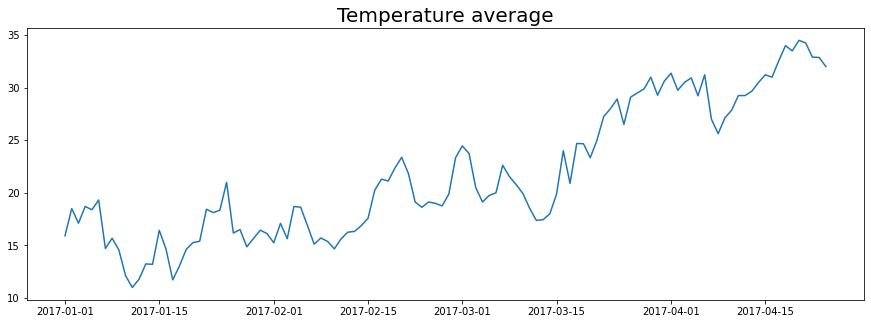

In [50]:
plt.figure(figsize=(15,5))
plt.plot(dates[len(data_train):], temp[len(data_train):])
plt.title('Temperature average', fontsize=20);

In [28]:
def Visualize(data, kind='hist',figsize=(10,10)):
    def Col():
        cols = ['temp',	'humidity',	'wind'	,'pressure']
        for c in cols:
            yield c

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    col = Col()
    for i in range(2):
        for j in range(2):
            curr = next(col)
            if kind == 'hist':
                axes[i,j].hist(data[curr])
            elif kind == 'plot':
                axes[i,j].plot(data['date'],data[curr])
                plt.gcf().autofmt_xdate()
            axes[i,j].set_title(curr)

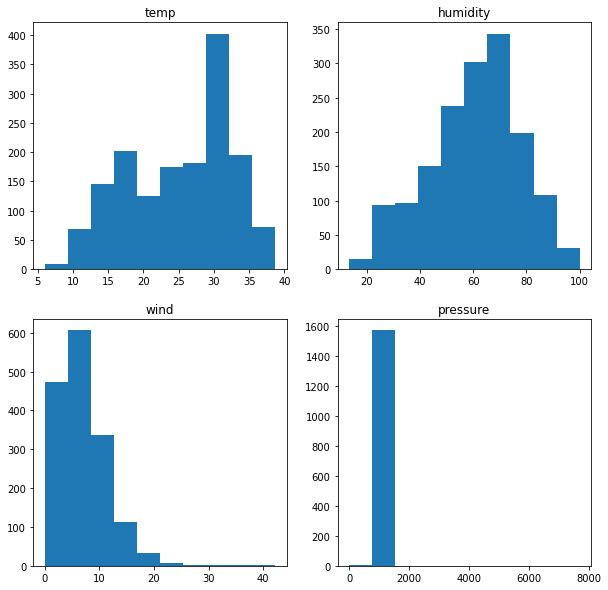

In [30]:
Visualize(data)

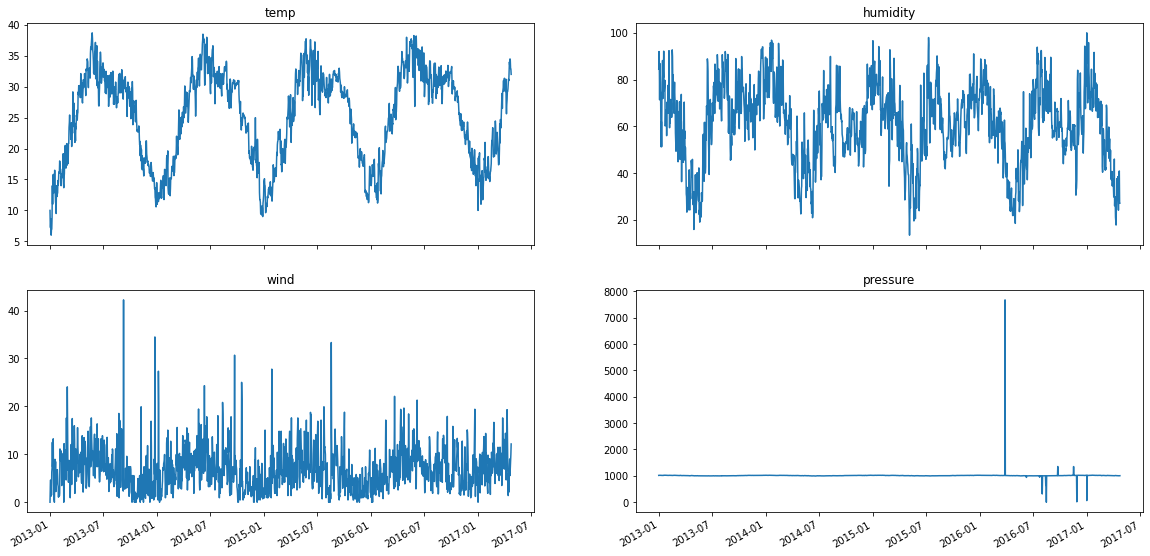

In [31]:
Visualize(data, 'plot', (20,10))

In [33]:
scaler = MinMaxScaler()
transformed = scaler.fit_transform(data.loc[:, ["humidity","wind","pressure"]])
transformed

array([[0.8209571 , 0.        , 0.13260331],
       [0.90759076, 0.07058266, 0.132881  ],
       [0.84983498, 0.10974262, 0.13299381],
       ...,
       [0.31732673, 0.21056371, 0.13077228],
       [0.16254125, 0.23596637, 0.13084061],
       [0.15841584, 0.28794749, 0.13110328]])

In [34]:
transformed = pd.DataFrame(transformed, columns = ["humidity","wind","pressure"])
transformed.head()

,humidity,wind,pressure
0,0.820957,0.000000,0.132603
1,0.907591,0.070583,0.132881
2,0.849835,0.109743,0.132994
3,0.668867,0.029212,0.132799
4,0.847910,0.087636,0.132712


In [17]:
dates = data['date'].values
temp = data['temp'].values
humidity = data['humidity'].values
wind = data['wind'].values
pressure = data['pressure'].values

In [35]:
humidity_s = transformed['humidity'].values
wind_s = transformed['wind'].values
pressure_s = transformed['pressure'].values

In [42]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[5 6 7 8]
 [4 5 6 7]]
y =  [[9]
 [8]]
x =  [[2 3 4 5]
 [0 1 2 3]]
y =  [[6]
 [4]]
x =  [[1 2 3 4]
 [3 4 5 6]]
y =  [[5]
 [7]]


In [43]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [44]:
train_length = len(data_train)
print(train_length)

1462


In [51]:
train_temp = windowed_dataset(temp[:train_length], window_size=60, batch_size=100, shuffle_buffer=1000)
test_temp = windowed_dataset(temp[train_length:], window_size=60, batch_size=4, shuffle_buffer=4)

In [53]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [58]:
earlyStoping = EarlyStopping(monitor='loss',patience=3)

In [59]:
history = model.fit(train_temp, epochs=100, validation_data=test_temp)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 95ms/step - loss: 25.4595 - mae: 25.9595 - val_loss: 20.3656 - val_mae: 20.8656
Epoch 2/100
15/15 [==============================] - 1s 38ms/step - loss: 25.2431 - mae: 25.7431 - val_loss: 20.1397 - val_mae: 20.6397
Epoch 3/100
15/15 [==============================] - 1s 39ms/step - loss: 25.0589 - mae: 25.5589 - val_loss: 19.9971 - val_mae: 20.4971
Epoch 4/100
15/15 [==============================] - 1s 39ms/step - loss: 24.9136 - mae: 25.4136 - v